<a href="https://colab.research.google.com/github/sarenales/OFA-VSR/blob/main/ejemplo_infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA SET

In [ ]:
!git clone https://github.com/cambridgeltl/visual-spatial-reasoning.git

Cloning into 'visual-spatial-reasoning'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 253 (delta 37), reused 17 (delta 17), pack-reused 204
Receiving objects: 100% (253/253), 10.98 MiB | 18.90 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [ ]:
import json
archivo_jsonl = "/content/visual-spatial-reasoning/data/data_files/all_vsr_validated_data.jsonl"
train = []
with open(archivo_jsonl, "r") as f:
  for linea in f:
    objeto = json.loads(linea)
    train.append(objeto)

In [ ]:
train

[{'image': '000000239417.jpg',
  'image_link': 'http://images.cocodataset.org/train2017/000000239417.jpg',
  'caption': 'The bench is at the right side of the train.',
  'label': 0,
  'relation': 'at the right side of',
  'annotator_id': 1,
  'vote_true_validator_id': '[]',
  'vote_false_validator_id': '[2, 10, 1]',
  'reference_frame': None},
 {'image': '000000224670.jpg',
  'image_link': 'http://images.cocodataset.org/train2017/000000224670.jpg',
  'caption': 'The train contains the laptop.',
  'label': 1,
  'relation': 'contains',
  'annotator_id': 30,
  'vote_true_validator_id': '[2, 67, 21]',
  'vote_false_validator_id': '[]',
  'reference_frame': None},
 {'image': '000000266622.jpg',
  'image_link': 'http://images.cocodataset.org/train2017/000000266622.jpg',
  'caption': 'The bowl is at the left side of the banana.',
  'label': 1,
  'relation': 'at the left side of',
  'annotator_id': 2,
  'vote_true_validator_id': '[13, 2, 1]',
  'vote_false_validator_id': '[]',
  'reference_fra

In [ ]:
diccionario_opuesto ={
    # Adjacency (10)
    "Adjacent to":"alongside",
    "alongside": "Adjacent to",
    "at the side of":"against",
    "at the right side of":"at the left side of",
    "at the left side of": "at the right side of",
    "attached to":"against",
    "at the back of":"ahead of",
    "ahead of":"at the back of",
    "against": "ahead of",
    "at the edge of":"Adjacent to",

  # Directional (16)
    "off":"up",
    "past":"across from",
    "toward":"down",
    "down":"up",
    "deep down":"up",
    "up":"deep down",
    "away from":"across from",
    "along":"Adjacent to",
    "around":"off",
    "from":"away from",
    "into":"off",
    "to":"in front of",
    "across":"off"  ,
    "across from":"Adjacent to" ,
    "through":"Adjacent to",
    "down from":"into"    ,

  # Orientation (4)
    "facing":"facing away from"  ,
    "facing away from":"facing"  ,
    "parallel to":"perpendicular to"  ,
    "perpendicular to":"parallel to"  ,

  # Projective (12)
    "on top of":"beneath"  ,
    "beneath":"on top of"  ,
    "beside":"far from"  ,
    "behind":"in front of"  ,
    "left of":"right of"  ,
    "right of":"left of"  ,
    "under":"over"  ,
    "in front of":"behind"  ,
    "below":"above"  ,
    "above":"below"  ,
    "over":"under"  ,
    "in the middle of": "above",

    # Proximity (6)
    "by":"far from"  ,
    "close to": "far from" ,
    "near":"far from"  ,
    "far from":"close to"  ,
    "far away from":"close to"  ,

    # Topological (18)
    "Connected to":"detached from"  ,
    "detached from":"part of"  ,
    "has as a part":"detached from"  ,
    "part of":"detached from"  ,
    "contains":"detached from"  ,
    "within":"out of"  ,
    "at":"out of"  ,
    "on":"out of"  ,
    "in":"out of"  ,
    "with":"out of"  ,
    "surrounding":"out of"  ,
    "among":"out of"  ,
    "consists of":"out of"  ,
    "out of":"between"  ,
    "between":"out to"  ,
    "inside":"outside"  ,
    "outside":"inside"  ,
    "touching": "detached from"  ,

    # Unallocated (6)
    "beyond":"enclosed by"  ,
    "next to":"beyond"  ,
    "opposite to":"Adjacent to"  ,
    "after":"among"  ,
    #"among":"after"  ,
    "enclosed by":"beyond"
}


In [ ]:
def obtener_contrario(palabra, diccionario):
  if palabra in diccionario:
    return diccionario[palabra]
  else:
    return "Palabra no encontrada"

In [ ]:
def saber_split(url):
  if 'train' in url:
    return "train"
  else:
    return "dev"

In [ ]:
filtro = {}
cont = 0

for elemento in train:
  if elemento.get("label") == 1:
    cont +=1
    texto = elemento.get("caption")
    captionN = texto.replace(elemento.get("relation"),  obtener_contrario(elemento.get("relation"), diccionario_opuesto))

    nuevo_elemento = {
        "image" : elemento.get("image"),
        "image_link": elemento.get("image_link"),
        "caption+" : elemento.get("caption"),
        "caption-" : captionN,
        "annotator_id" : str(elemento.get("annotator_id")),
        "relation+" : elemento.get("relation"),
        "relation-" : obtener_contrario(elemento.get("relation"), diccionario_opuesto),
        "split": saber_split(elemento.get("image_link"))
    }
    filtro[elemento.get("image")] = nuevo_elemento

with open("filtrado.json", "w") as archivo:
  json.dump(filtro, archivo)

print(cont)
print("Nuevo JSON creado exitosamente con los elementos filtrados.")

5621
Nuevo JSON creado exitosamente con los elementos filtrados.


In [ ]:
filtro

{'000000224670.jpg': {'image': '000000224670.jpg',
  'image_link': 'http://images.cocodataset.org/train2017/000000224670.jpg',
  'caption+': 'The laptop is inside the train.',
  'caption-': 'The laptop is outside the train.',
  'annotator_id': '27',
  'relation+': 'inside',
  'relation-': 'outside',
  'split': 'train'},
 '000000266622.jpg': {'image': '000000266622.jpg',
  'image_link': 'http://images.cocodataset.org/train2017/000000266622.jpg',
  'caption+': 'The bowl is at the left side of the banana.',
  'caption-': 'The bowl is at the right side of the banana.',
  'annotator_id': '2',
  'relation+': 'at the left side of',
  'relation-': 'at the right side of',
  'split': 'train'},
 '000000080336.jpg': {'image': '000000080336.jpg',
  'image_link': 'http://images.cocodataset.org/train2017/000000080336.jpg',
  'caption+': 'The cow is at the back of the person.',
  'caption-': 'The cow is ahead of the person.',
  'annotator_id': '27',
  'relation+': 'at the back of',
  'relation-': 'ahe

# OFA infering


In [ ]:
!git clone --single-branch --branch feature/add_transformers https://github.com/OFA-Sys/OFA.git
!pip install OFA/transformers/
!git clone https://huggingface.co/OFA-Sys/OFA-large-caption

Cloning into 'OFA'...
remote: Enumerating objects: 5745, done.
remote: Counting objects: 100% (932/932), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 5745 (delta 710), reused 676 (delta 676), pack-reused 4813
Receiving objects: 100% (5745/5745), 97.78 MiB | 13.42 MiB/s, done.
Resolving deltas: 100% (2243/2243), done.
Processing ./OFA/transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 7.3 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.18.0.dev0-py3-none-any.whl size=3916748 sha256=12e8e053c7fe28224ef773a6ac398621cdb067fb2093d8256797f45048175b17
  Stored in directory: /tmp/pip-ephem-wheel-cache-mil_10qd/wheels/0b/bc/ea/00b6b8998c20c4fe55affe6062a2cddda80308ef9bd5d5877c
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transforme

In [ ]:
!git lfs install
!git clone https://huggingface.co/OFA-Sys/OFA-base

Git LFS initialized.
Cloning into 'OFA-base'...
remote: Enumerating objects: 52, done.
remote: Total 52 (delta 0), reused 0 (delta 0), pack-reused 52 (from 1)
Unpacking objects: 100% (52/52), 541.04 KiB | 8.59 MiB/s, done.


In [ ]:
from transformers import OFATokenizer, OFAModel
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ofa_model = OFAModel.from_pretrained("./OFA-base", use_cache=False).to(device)
ofa_tokenizer = OFATokenizer.from_pretrained("./OFA-base")

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


./OFA-base
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [ ]:
from PIL import Image
from torchvision import transforms

mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480


def load_image(image):
    patch_resize_transform = transforms.Compose([
            transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    patch_img = patch_resize_transform(image).unsqueeze(0).to(device)
    return patch_img

In [ ]:
ejemplo = {'image': '000000574696.jpg',
  'image_link': 'http://images.cocodataset.org/train2017/000000574696.jpg',
  'caption+': 'The zebra is far away from the car.',
  'caption-': 'The zebra is close to the car.',
  'annotator_id': '2',
  'relation+': 'far away from',
  'relation-': 'close to',
  'split': 'train'}

In [ ]:
ejemplo3 = {'image': '000000424912.jpg',
  'image_link': 'http://images.cocodataset.org/train2017/000000424912.jpg',
  'caption+': 'The person is on top of the horse.',
  'caption-': 'The person is beneath the horse.',
  'annotator_id': '27',
  'relation+': 'on top of',
  'relation-': 'beneath',
  'split': 'train'}

In [ ]:
ejemplo1 = { 'image': '000000556341.jpg',
  'image_link': 'http://images.cocodataset.org/train2017/000000556341.jpg',
  'caption+': 'The zebra is at the right side of the person.',
  'caption-': 'The zebra is at the left side of the person.',
  'annotator_id': '27',
  'relation+': 'at the right side of',
  'relation-': 'at the left side of',
  'split': 'train'}

#1

In [ ]:
import numpy as np
import requests
import math
from torch import nn
from io import BytesIO
from tabulate import tabulate


In [ ]:
def token_imag(url):
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  patch_img = load_image(image.convert("RGB"))
  return patch_img, image

In [ ]:
def token_cap(caption):
  cap = "Does the image describe the following sentence?  " + caption
  text = ofa_tokenizer([cap], padding=True, truncation=True, return_tensors="pt").to(device).input_ids
  return text,cap

In [ ]:
def input_model(caption, patch_img):
  gen_output_0 = ofa_model.generate(caption, patch_images=patch_img,num_beams=1, no_repeat_ngram_size=1,  return_dict_in_generate=True , output_scores=True )
  ofa_caption_0 = ofa_tokenizer.batch_decode(gen_output_0[0], skip_special_tokens=True)[0].strip()
  return ofa_caption_0, gen_output_0

In [ ]:
def get_probabilidades(gen_output_0):
  probabilities = nn.functional.softmax(gen_output_0[1][0], dim=-1)
  probYES = probabilities[0][tokens.get("yes")].item()
  probNO = probabilities[0][tokens.get("no")].item()
  return probYES, probNO

In [ ]:
def comprobar_primera_p(ofa_caption_0):
    palabras = ofa_caption_0.split()
    yn = ["yes", "no","yes,","no,","yes.","no.","yes..", "no..", "yes!","no!", "yes...","no..."]
    if not palabras:
        return False
    elif palabras[0].lower() in yn:
      return True
    return False

def comprobar_primera_yes(ofa_caption_0):
  palabras = ofa_caption_0.split()
  if not palabras:
    return False
  elif palabras[0].lower() == "yes":
    return True
  return False

In [ ]:
def convert_response_to_label(response):
  palabras = response.split()
  if not palabras:
    return -1
  y = ["yes", "yes,","yes.","yes..",  "yes!","yes..."]
  n = [ "no","no,","no.", "no..", "no!", "no..."]
  if palabras[0].lower() in y :
      return 1
  elif palabras[0].lower() in n:
      return 0
  else:
      return -1

In [ ]:
resultados = {}
tokens = ofa_tokenizer.get_vocab()

cont = 0

probYESP = 0.0
probNOP = 0.0
probYESN = 0.0
probNON = 0.0
respP = ""
respN = ""

url = ejemplo["image_link"]
patch_img,image = token_imag(url)

caption = token_cap(ejemplo["caption+"])[0]
ofa_caption_0, gen_output_0 = input_model(caption, patch_img)
respP = ofa_caption_0

if comprobar_primera_p(ofa_caption_0):
  probYESP, probNOP = get_probabilidades(gen_output_0)

  caption = token_cap(ejemplo["caption-"])[0]
  ofa_caption_1, gen_output_1 = input_model(caption, patch_img)
  respN = ofa_caption_1
  if comprobar_primera_p(ofa_caption_1):
    probYESN, probNON = get_probabilidades(gen_output_1)

ejemplo["PY+"] = probYESP
ejemplo["PN+"] = probNOP
ejemplo["response+"] = respP
ejemplo["PY-"] = probYESN
ejemplo["PN-"] = probNON
ejemplo["response-"] = respN


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


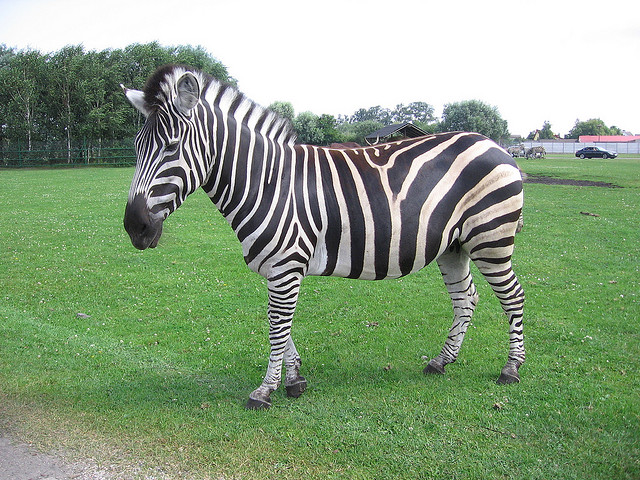

In [ ]:
image

In [ ]:

print(token_cap(ejemplo["caption+"])[1])
print("OFA caption + :",ofa_caption_0)
print("OFA caption - :",ofa_caption_1)

Does the image describe the following sentence?  The zebra is far away from the car.
OFA caption + : yes
OFA caption - : yes


In [ ]:
y_pred = []
y_true = []
predicciones_correctas_solo_yes = 0
predicciones_correctas_solo_yesNo = 0


acierto_yes = convert_response_to_label(ejemplo["response+"])
y_pred.append(acierto_yes)
y_true.append(1)
acierto_no = convert_response_to_label(ejemplo["response-"])
y_pred.append(acierto_no)
y_true.append(0)
if acierto_yes == 1:
  predicciones_correctas_solo_yes += 1
  if acierto_no == 0:
    predicciones_correctas_solo_yesNo += 1

total_predicciones = 1
accuracy_yes = predicciones_correctas_solo_yes / total_predicciones
accuracy_yesNo = predicciones_correctas_solo_yesNo / total_predicciones

print("Número de predicciones correctas cap1-Yes:               ", predicciones_correctas_solo_yes)
print("Número de predicciones correctas cap1-Yes & cap2-No:     ", predicciones_correctas_solo_yesNo)
print("Total de predicciones:                                   ", total_predicciones)
print("--------------------------------------------------------------------------------")
print("Accuracy yes:                                             ", accuracy_yes)
print("Accuracy yes&no:                                          ", accuracy_yesNo)

Número de predicciones correctas cap1-Yes:                1
Número de predicciones correctas cap1-Yes & cap2-No:      0
Total de predicciones:                                    1
--------------------------------------------------------------------------------
Accuracy yes:                                              1.0
Accuracy yes&no:                                           0.0


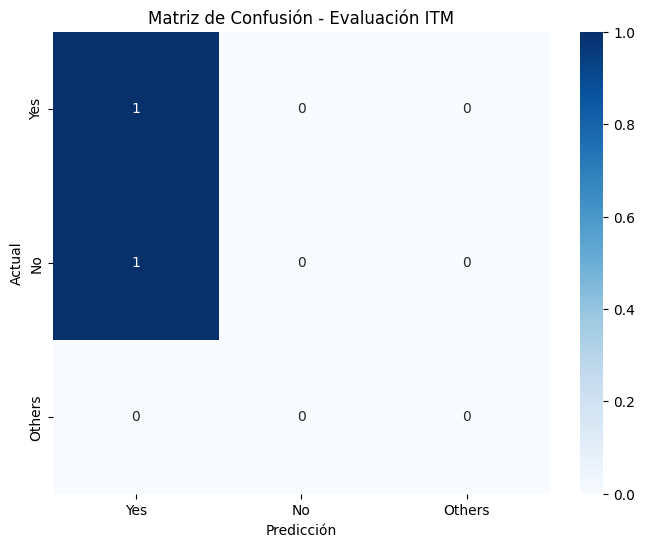

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


conf_matrix = confusion_matrix(y_true, y_pred, labels=[1, 0, -1])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Yes', 'No', 'Others'], yticklabels=['Yes', 'No', 'Others'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Evaluación ITM')
plt.show()

#2

In [ ]:
def acierta_1(PYP,PNP,PYN,PNN):
  DP = abs(PYP - PNP)
  DN = abs(PYN - PNN)

  if DN == 0.0:
    return 0
  if DP == 0.0:
    return 0

  if DP > DN :
    return 1
  return 0

In [ ]:
datos_filtrados = []


rel_esp = ejemplo["relation+"]
acierto = acierta_1(ejemplo["PY+"],ejemplo["PN+"],ejemplo["PY-"],ejemplo["PN-"])
datos_filtrados.append({"relacion_espacial": rel_esp, "acierto": acierto})

In [ ]:
predicciones_correctas = sum(1 for instancia in datos_filtrados if instancia["acierto"] == 1)

total_predicciones = len(datos_filtrados)

accuracy = predicciones_correctas / total_predicciones

print("Número de predicciones correctas:  ", predicciones_correctas)
print("Total de predicciones:             ", total_predicciones)
print("------------------------------------------------------")
print("Accuracy:                          ", accuracy)

Número de predicciones correctas:   1
Total de predicciones:              1
------------------------------------------------------
Accuracy:                           1.0


In [ ]:
ejemplo["PY+"]

1.905439785332419e-05

In [ ]:
Diferencia_positiva = abs(1.905439785332419e-05 - 8.450302857454517e-07)
Diferencia_positiva

1.8209367567578738e-05

In [ ]:
Diferencia_negativa = abs(1.5759196685394272e-05 - 7.716470236118766e-07)
Diferencia_negativa

1.4987549661782396e-05

In [ ]:
Diferencia_positiva > Diferencia_negativa

True

In [ ]:
probabilidad_total_positiva = 1.905439785332419e-05 + 8.450302857454517e-07
probabilidad_yes_positiva = 1.905439785332419e-05 / probabilidad_total_positiva
probabilidad_no_positiva = 8.450302857454517e-07 / probabilidad_total_positiva
Diferencia_positiva = abs(probabilidad_yes_positiva - probabilidad_no_positiva)
Diferencia_positiva

0.9150698924773264

In [ ]:
probabilidad_total_negativa = 1.5759196685394272e-05 + 7.716470236118766e-07
probabilidad_yes_negativa = 1.5759196685394272e-05 / probabilidad_total_negativa
probabilidad_no_negativa = 7.716470236118766e-07 / probabilidad_total_negativa
Diferencia_negativa = abs(probabilidad_yes_negativa - probabilidad_no_negativa)
Diferencia_negativa

0.9066415438685109

In [ ]:
Diferencia_positiva>Diferencia_negativa

True

In [ ]:
ejemplo["PN+"]

8.450302857454517e-07

In [ ]:
ejemplo["PY-"]

1.5759196685394272e-05

In [ ]:
ejemplo["PN-"]

7.716470236118766e-07

In [ ]:
def acierta_2(PYP,PNP,PYN,PNN):
  if PYP == 0.0:
    return 0
  if PYN == 0.0:
    return 0

  total_prob_p = PYP + PNP
  normalized_prob_yes_p = PYP / total_prob_p
  normalized_prob_no_p = PNP / total_prob_p

  total_prob_n = PYN + PNN
  normalized_prob_yes_n = PYN / total_prob_n
  normalized_prob_no_n = PNN / total_prob_n

  if normalized_prob_yes_p > normalized_prob_no_n:
    return 1
  return 0


In [ ]:
datos_filtrados = []


rel_esp = ejemplo["relation+"]
acierto = acierta_2(ejemplo["PY+"],ejemplo["PN+"],ejemplo["PY-"],ejemplo["PN-"])
datos_filtrados.append({"relacion_espacial": rel_esp, "acierto": acierto})

In [ ]:
predicciones_correctas = sum(1 for instancia in datos_filtrados if instancia["acierto"] == 1)

total_predicciones = len(datos_filtrados)

accuracy = predicciones_correctas / total_predicciones

print("Número de predicciones correctas:  ", predicciones_correctas)
print("Total de predicciones:             ", total_predicciones)
print("------------------------------------------------------")
print("Accuracy:                          ", accuracy)

# 3

In [ ]:
def probability_to_logit(p):
    p = p.item()
    if p == 0.0:
        return -10000
    return np.log(p)

In [ ]:
def partes(caption):
  partes = caption.split()
  palabras = []
  for parte in partes:
    palabras.extend(parte.split("."))
  palabras[-1] = "."
  palabras.append("</s>")
  return palabras

In [ ]:
import math
def pro_logs(logits_output, caption):
  sum_pro = 0
  mul_pro = 0
  suma_log1 = 0
  suma_log2 = 0



  datos = []
  datos.append(("Token", "Logit 1","Probabilidad de la siguiente", "Logit 2"))
  inputs_pal = []
  inputs_ids = []
  for i in partes(caption):
    inputs_pal.append(i)

  cont = 0
  for i in range(0, len(inputs_pal)-1):
    inputs_ids = (ofa_tokenizer(inputs_pal[i]).input_ids)
    for j in inputs_ids[1:-1]:
      probabilities = nn.functional.softmax(logits_output.logits, dim=-1)
      log_1 = logits_output.logits[0][cont][j].item()
      prob = probabilities[0][cont][j]
      log_2 = probability_to_logit(prob)
      datos.append((ofa_tokenizer.decode([j]), log_1, prob.item(), log_2))
      cont += 1
      suma_log1 += log_1
      sum_pro += prob
      mul_pro *= prob
      suma_log2 += log_2
  datos.append(("</s>", 0.0, 0.0, 0.0))
  print(tabulate(datos, headers="firstrow", tablefmt="grid"))
  print(f"Probabilidad media  : {(sum_pro/len(partes(caption))).item()} ")
  print(f"Mul probabilidades  : {mul_pro} ")
  print(f"Suma logits 1       : {suma_log1} ")
  print(f"Suma logits 2       : {suma_log2} ")

In [ ]:
ejemplo = {'image': '000000574696.jpg',
  'image_link': 'http://images.cocodataset.org/train2017/000000574696.jpg',
  'caption+': 'The zebra is far away from the car.',
  'caption-': 'The zebra is close to the car.',
  'annotator_id': '2',
  'relation+': 'far away from',
  'relation-': 'close to',
  'split': 'train'}

In [ ]:
import numpy as np
import requests
import math
from torch import nn
from io import BytesIO
from tabulate import tabulate

txt = "what does the image describe?"
inputs = ofa_tokenizer([txt], return_tensors="pt").to(device).input_ids

url = 'http://images.cocodataset.org/train2017/000000574696.jpg'
response = requests.get(url)
image = Image.open(BytesIO(response.content))
patch_img = load_image(image.convert("RGB"))

captionP = 'The zebra is far away from the car.'
captionN = 'The zebra is close to the car.'
capP = ofa_tokenizer([captionP], return_tensors="pt").to(device).input_ids
capN = ofa_tokenizer([captionN], return_tensors="pt").to(device).input_ids

tokens = ofa_tokenizer.get_vocab()

logits_output_P = ofa_model.forward(input_ids=inputs,patch_images=patch_img, decoder_input_ids=capP)
logits_output_N = ofa_model.forward(input_ids=inputs,patch_images=patch_img, decoder_input_ids=capN)
print(logits_output_P.logits.size())
print(logits_output_N.logits.size())

print("Caption +")
pro_logs(logits_output_P, captionP)


print("------------------------------------------------------------------------------")
print("Caption -")
pro_logs(logits_output_N, captionN)


torch.Size([1, 12, 59457])
torch.Size([1, 11, 59457])
Caption +
+---------+-----------+--------------------------------+---------------+
| Token   |   Logit 1 |   Probabilidad de la siguiente |       Logit 2 |
+=========+===========+================================+===============+
| The     | -12.8194  |                    3.88555e-12 | -26.2738      |
+---------+-----------+--------------------------------+---------------+
| z       |  -3.42412 |                    2.80559e-09 | -19.6917      |
+---------+-----------+--------------------------------+---------------+
| ebra    |  30.2573  |                    0.99989     |  -0.000110155 |
+---------+-----------+--------------------------------+---------------+
| is      |   1.01306 |                    1.00309e-06 | -13.8124      |
+---------+-----------+--------------------------------+---------------+
| far     |   2.92027 |                    1.0858e-05  | -11.4306      |
+---------+-----------+--------------------------------+----

In [ ]:
Probabilidad_media_correcta = 0.11133419722318649
Probabilidad_media_incorrecta = 0.11814431101083755
Probabilidad_media_correcta > Probabilidad_media_incorrecta

False